In [1]:
# Headers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline

import random

import healpy as hp

from astropy.io import fits
from astropy.table import Table, Column

import treecorr

from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.stats import moment, skew

In [2]:
def calculate_patch_radius(patch_area_sq_degrees):
    return np.arccos(1-patch_area_sq_degrees*np.pi/(2*180*180))

def lognormal_pdf(z, log_shift, sigma2):
    return np.piecewise(z, [z > -log_shift, z <= -log_shift], 
                        [ lambda z: 1/(np.sqrt(2*np.pi)*(z+log_shift)*np.sqrt(sigma2)) *
                         np.exp(-(np.log(z/log_shift + 1) + sigma2/2)**2/(2*sigma2)), 0])


def calculate_logshift_sigma2_mu(z):
    e_z1z2 = moment(z, moment=2) # 3rd central moment
    e_z1z2z3 = moment(z, moment=3) # 2nd central moment
    
    # Solving eq. B.11 of Hilbert et al. to get log-shift parameter
    def B_11(l_z):
        return 3*e_z1z2**2/l_z + (e_z1z2/l_z)**3 - e_z1z2z3
       
    l_z_guess = 1.0
    logshift = fsolve(B_11, l_z_guess)[0]
    
    # Find sigma2 of underlying normal distribution using eq. B.8 of Hilbert et al
    sigma2 = np.log(logshift**-2*e_z1z2 + 1)
    
    mu = np.log(logshift)-sigma2/2

    return np.array([logshift, sigma2, mu])

In [3]:
def fit_lognormal_pdf(density_field, no_of_bins, sq_degrees=40000):
    
    if (sq_degrees == 40000): # i.e. full sky
        
        #no_of_bins = 500
               
        bin_values, bin_edges = np.histogram(density_field, bins=no_of_bins, density=True)
        bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

        # Fit the function to the histogram data to get the optimized parameter values
        #popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, p0=[1, 0.5])
        popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, bounds=(0, np.inf))
        
        # Calculate using formulae from Hilbert et al
        calculated_vals = calculate_logshift_sigma2_mu(density_field)

        # Generate enough x values to make the curves look smooth.
        x_space = np.linspace(-2, 8, 1000)

        plt.figure(figsize=(10,10))
        plt.hist(density_field, bins=no_of_bins, density=True, label=r'Histogram entries')
        plt.plot(x_space, lognormal_pdf(x_space, *popt), color='r', linewidth=2.5, label=r'Fitted function')
        plt.plot(x_space, lognormal_pdf(x_space, calculated_vals[0], calculated_vals[1]), color='y', linewidth=2.5, label=r'Calculated function')
        plt.xlabel('density fluctuations ($δ$)', fontsize=16)
        plt.tick_params(labelsize=16)
        plt.xlim(-2,8)
        plt.title('1-pt PDF density fluctuations '+map_type+' map : {0} entries\nFit: λ = {1:4.3f}, $σ^2$ = {2:4.3f}, μ = {3:4.3f}\nCalculated values: λ = {4:4.3f}, $σ^2$ = {5:4.3f}, μ = {6:4.3f}'.format(density_field.size, popt[0], popt[1], np.log(popt[0])-popt[1]/2, calculated_vals[0], calculated_vals[1], calculated_vals[2]), fontsize=14)
        plt.legend(loc='best', fontsize=14)
        
    else:
        patch_radius = calculate_patch_radius(sq_degrees)

        # Center of spherical cap around at random_pixel around which to take sq_degrees area
        disc_center = hp.pix2vec(nside, random_pixel)

        # radius (in radians) corresponding to area of spherical cap in sky

        # find the pixels 
        pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)
        density_field_disc = density_field[pixels_indices_disc]
        
        #no_of_bins = 'auto'

        bin_values, bin_edges = np.histogram(density_field_disc, bins=no_of_bins, density=True)
        bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

        # Fit the function to the histogram data to get the optimized parameter values
        #popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, p0=[1, 0.5])
        popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, bounds=(0, np.inf))
        
        # Calculate using formulae from Hilbert et al
        calculated_vals = calculate_logshift_sigma2_mu(density_field_disc)

        # Generate enough x values to make the curves look smooth.
        x_space = np.linspace(-2, 8, 1000)

        plt.figure(figsize=(10,10))
        plt.hist(density_field_disc, bins=no_of_bins, density=True, label=r'Histogram entries')
        plt.plot(x_space, lognormal_pdf(x_space, *popt), color='r', linewidth=2.5, label=r'Fitted function')
        plt.plot(x_space, lognormal_pdf(x_space, calculated_vals[0], calculated_vals[1]), color='y', linewidth=2.5, label=r'Calculated function')
        plt.xlabel('density fluctuations ($δ$)', fontsize=16)
        plt.tick_params(labelsize=16)
        plt.xlim(-2,8)
        plt.title('1-pt PDF density fluctuations '+map_type+' map (single patch {0:4.2f} sq. degrees) {1} entries\nFit: λ = {2:4.3f}, $σ^2$ = {3:4.3f}, μ = {4:4.3f}\nCalculated values: λ = {5:4.3f}, $σ^2$ = {6:4.3f}, μ = {7:4.3f}'.format(sq_degrees, density_field_disc.size, popt[0], popt[1], np.log(popt[0])-popt[1]/2, calculated_vals[0], calculated_vals[1], calculated_vals[2]), fontsize=14)
        plt.legend(loc='best', fontsize=14)    
        
    return np.array([[popt[0], popt[1], np.log(popt[0])-popt[1]/2], [calculated_vals[0], calculated_vals[1], calculated_vals[2]]])
        

NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


<Figure size 864x864 with 0 Axes>

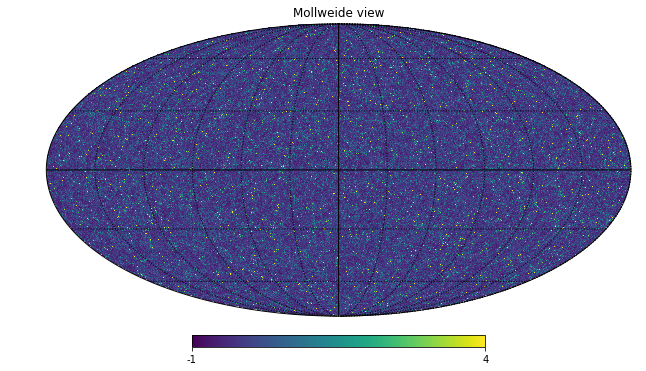

In [4]:
number_field_mice = hp.fitsfunc.read_map('../data/Mice_data/mice_number_field.fits')
mean_number = np.mean(number_field_mice)
density_field_map = (number_field_mice - mean_number) / mean_number

map_type = 'mice'

plt.figure(figsize=(12,12))
hp.mollview(density_field_map, min=-1, max=4)
hp.graticule()

In [5]:
np.mean(density_field_map)

-4.051076242401567e-17

In [6]:
nside = 2048

random_pixel = random.randint(0,12*nside**2)
print('Random pixel = ', random_pixel)

Random pixel =  35417716


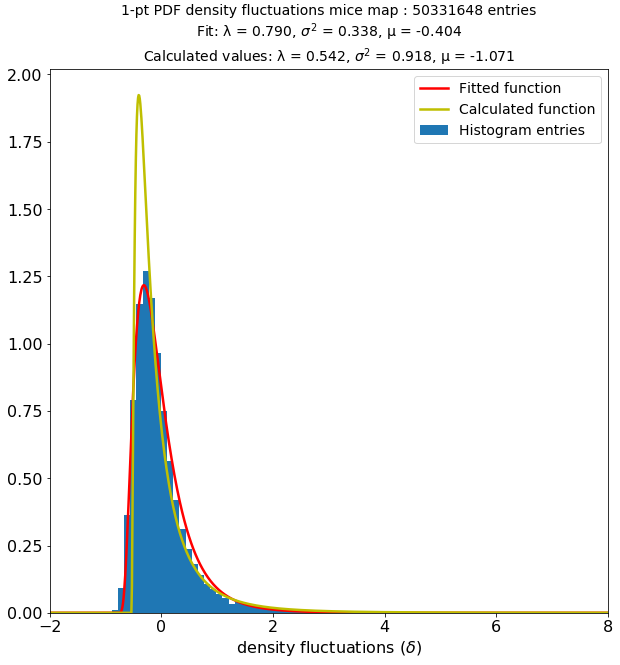

In [7]:
fit_params, calc_params = fit_lognormal_pdf(density_field_map, 500) # full sky

full_map_fit_log_shift, full_map_fit_sigma2, full_map_fit_mean  = fit_params
full_map_calc_log_shift, full_map_calc_sigma2, full_map_calc_mean  = calc_params

array([[ 0.77710886,  0.39540983, -0.44987975],
       [ 0.53219639,  0.89350077, -1.07749309]])

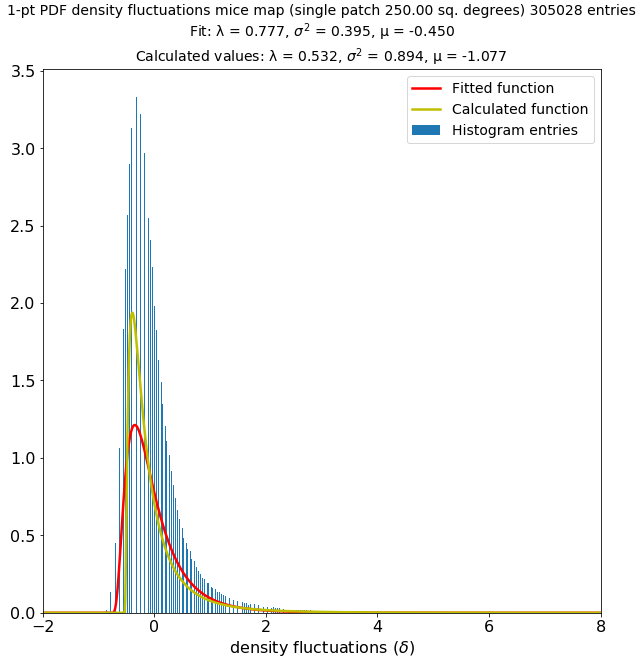

In [8]:
fit_lognormal_pdf(density_field_map, 'auto', 250)

array([[ 0.71824743,  0.574236  , -0.61805916],
       [ 0.48106003,  0.80711488, -1.13532066]])

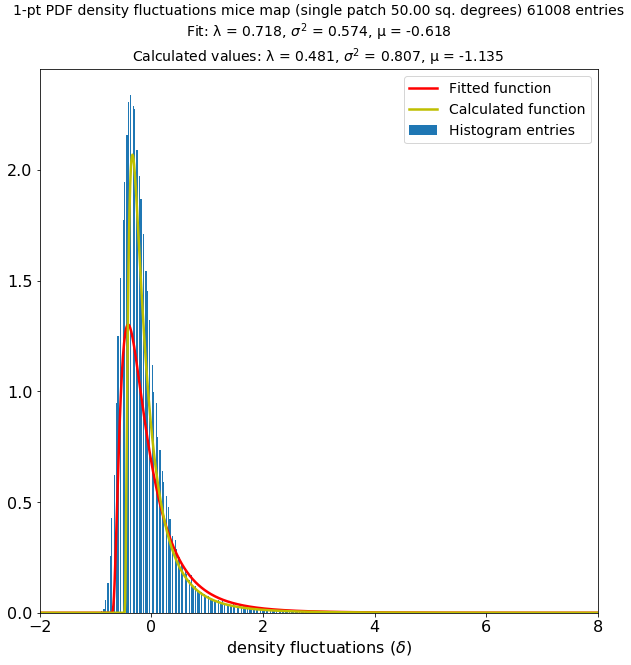

In [9]:
fit_lognormal_pdf(density_field_map, 'auto', 50)

array([[ 0.67367116,  0.67017839, -0.73010237],
       [ 0.42574237,  0.93148508, -1.31966343]])

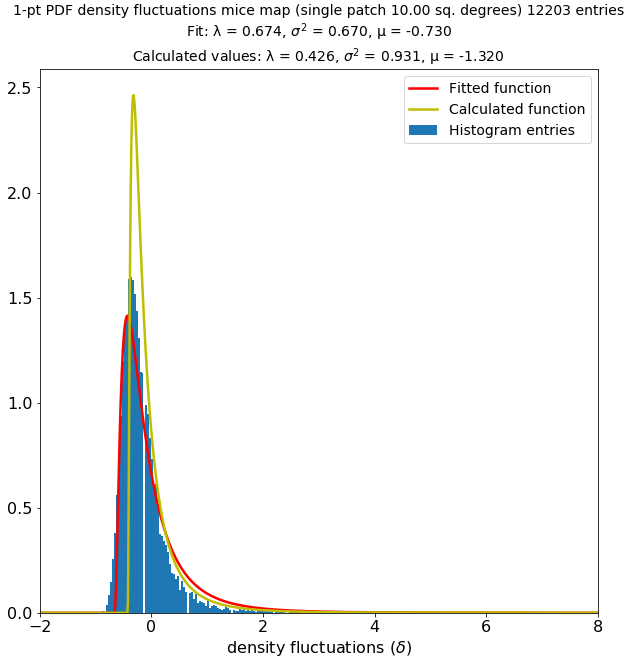

In [10]:
fit_lognormal_pdf(density_field_map, 'auto', 10)

array([[ 0.70037692,  0.48653306, -0.59940316],
       [ 0.47577648,  0.79587936, -1.1407468 ]])

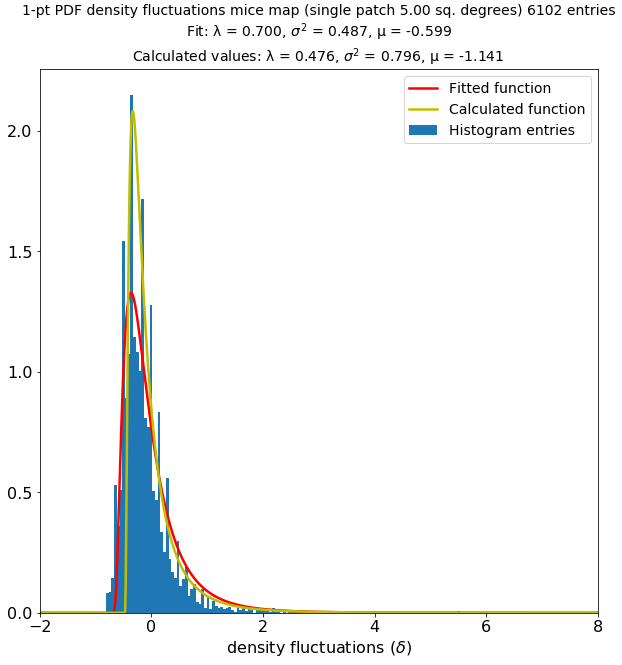

In [11]:
fit_lognormal_pdf(density_field_map, 'auto', 5)

array([[ 0.7145705 ,  0.40983238, -0.54098981],
       [ 0.62341742,  0.47067469, -0.70787631]])

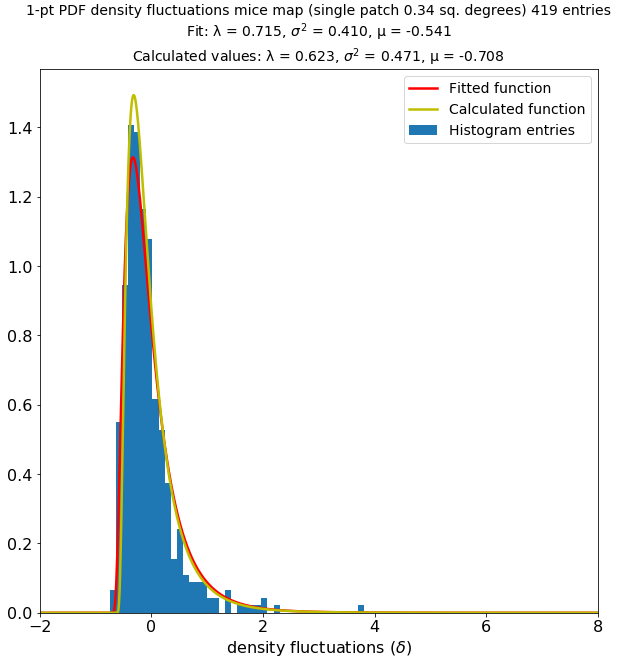

In [12]:
fit_lognormal_pdf(density_field_map, 'auto', 0.34)

# 1. Log-shift and sigma2 parameters via 2 methods (various patch sizes)

### Estimating log-shift and sigma2 parameters

/home/anik/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


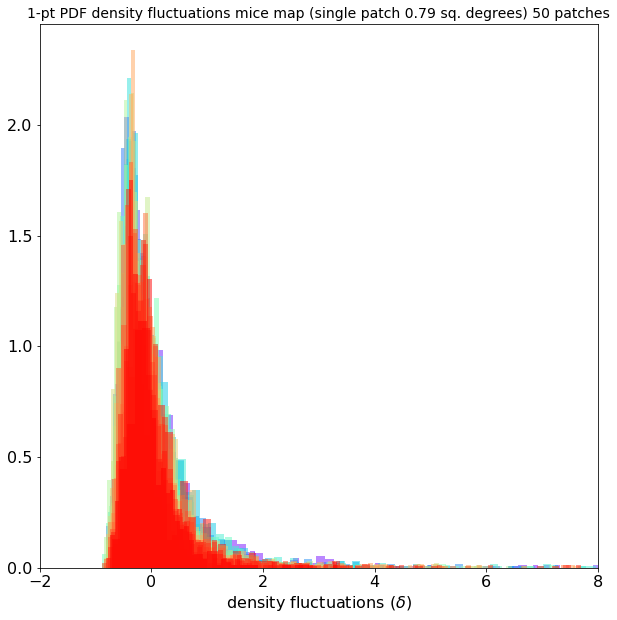

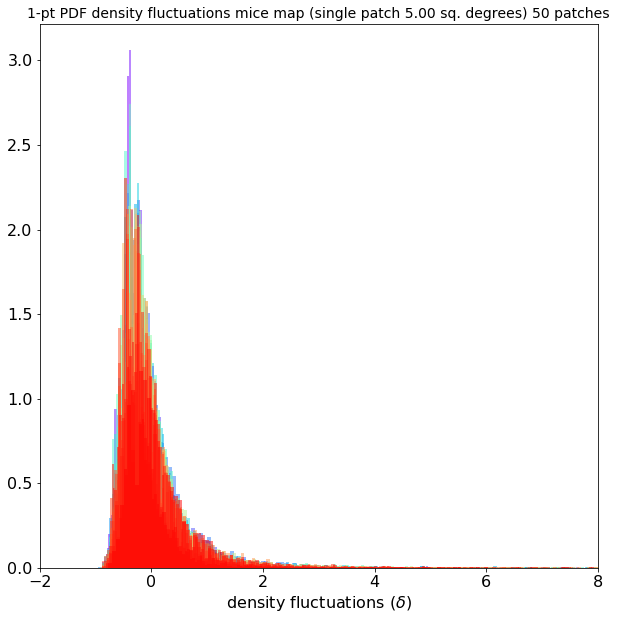

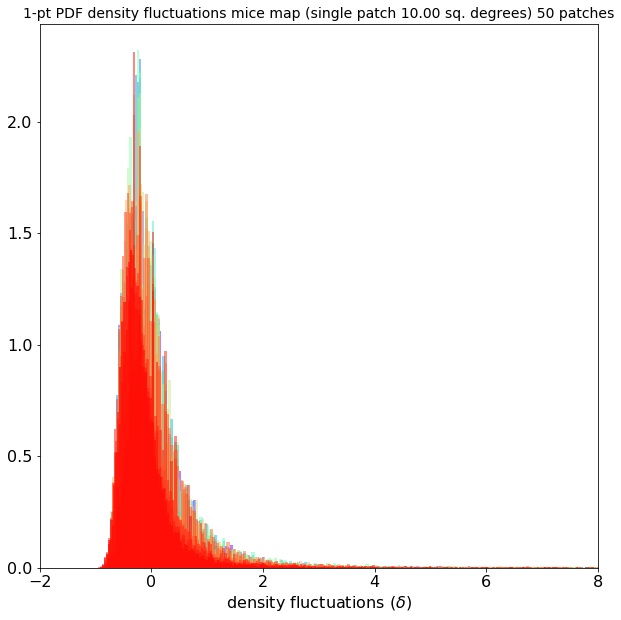

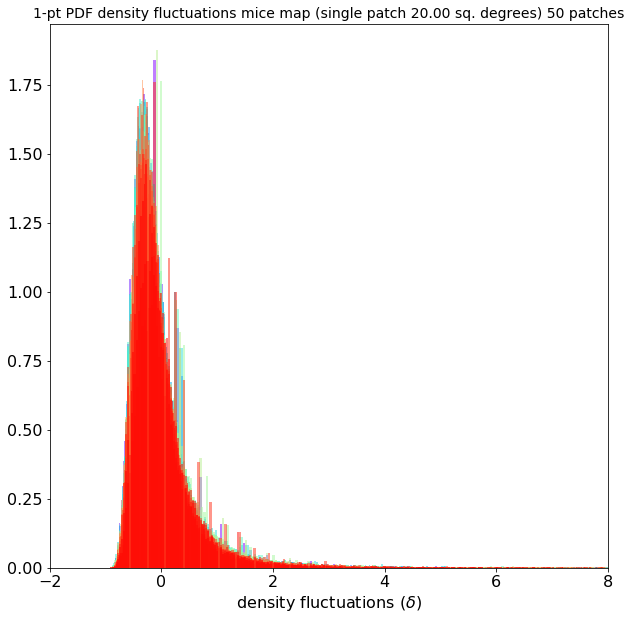

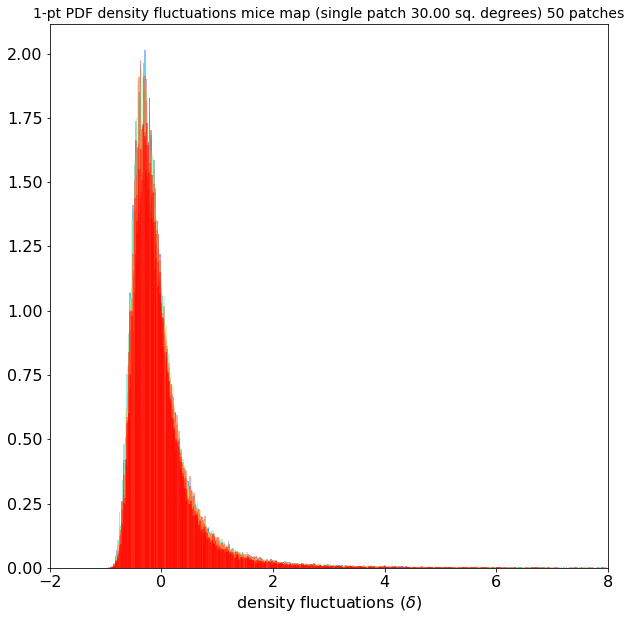

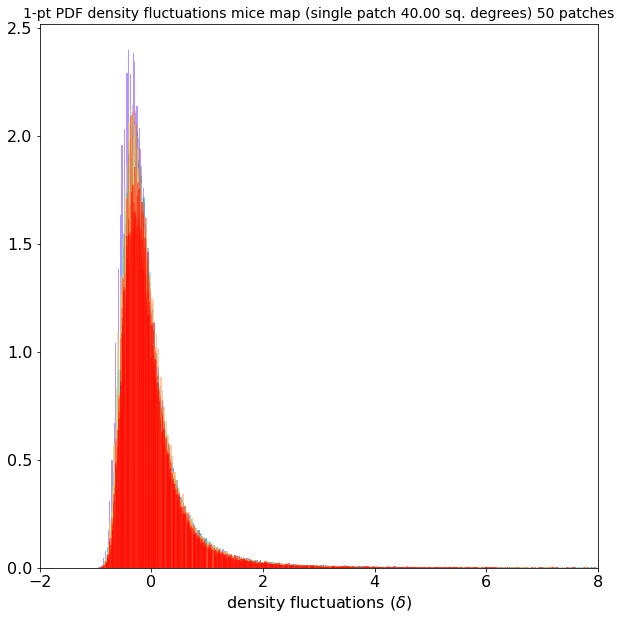

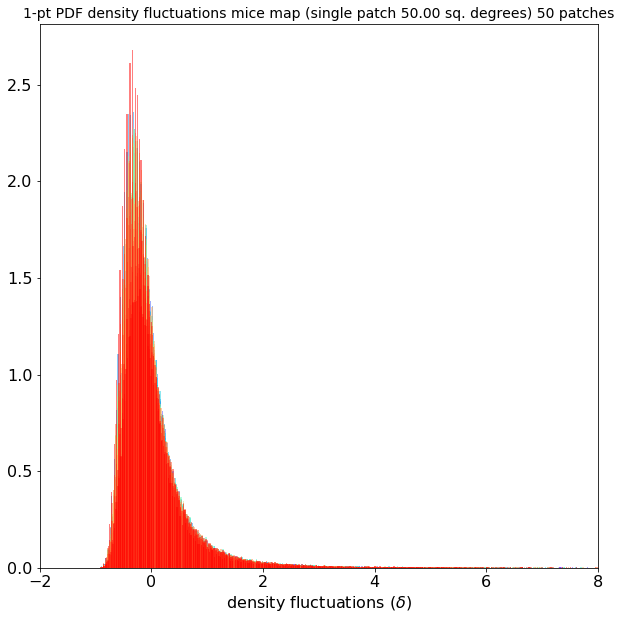

In [13]:
list_sq_degrees = [np.pi*(30/60)**2, 5, 10, 20, 30, 40, 50]
list_no_patches = [50, 50, 50, 50, 50, 50, 50]

#list_no_patches = []
#for j in range(len(list_sq_degrees)):
#    list_no_patches.append(int(40000/list_sq_degrees[j]))
    
dict_lambda_fit = {}
dict_lambda_calc = {}

dict_sigma2_fit = {}
dict_sigma2_calc = {}

for k in range(len(list_sq_degrees)):
    sq_degrees = list_sq_degrees[k]
    patch_radius = calculate_patch_radius(sq_degrees)

    no_of_patches = list_no_patches[k]

    lambda_fit = np.zeros(no_of_patches)
    lambda_calc = np.zeros(no_of_patches)
    
    sigma2_fit = np.zeros(no_of_patches)
    sigma2_calc = np.zeros(no_of_patches)

    plt.figure(figsize=(10,10))

    colors = cm.rainbow(np.linspace(0,1,no_of_patches))

    for i in range(no_of_patches):
        random_pixel = random.randint(0,12*nside**2)

        # Center of spherical cap around at random_pixel around which to take sq_degrees area
        disc_center = hp.pix2vec(nside, random_pixel)

        # find the pixels 
        pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)
        density_field_disc = density_field_map[pixels_indices_disc]

        bin_values, bin_edges = np.histogram(density_field_disc, bins='auto', density=True)
        bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

        # Fit the function to the histogram data to get the optimized parameter values
        #popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, p0=[1, 0.5])
        popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, bounds=(0, np.inf))

        # Calculate using formulae from Hilbert et al
        calculated_vals = calculate_logshift_sigma2_mu(density_field_disc)

        plt.hist(density_field_disc, bins='auto', density=True, color=colors[i], alpha=0.5)

        lambda_fit[i] = popt[0]
        sigma2_fit[i] = popt[1]
        lambda_calc[i] = calculated_vals[0]
        sigma2_calc[i] = calculated_vals[1]
        
    plt.xlabel('density fluctuations ($δ$)', fontsize=16)
    plt.tick_params(labelsize=16)
    plt.xlim(-2,8)
    plt.title('1-pt PDF density fluctuations '+map_type+' map (single patch {0:4.2f} sq. degrees) {1} patches'.format(sq_degrees, no_of_patches), fontsize=14)

    dict_lambda_fit[list_sq_degrees[k]] = lambda_fit
    dict_lambda_calc[list_sq_degrees[k]] = lambda_calc
    
    dict_sigma2_fit[list_sq_degrees[k]] = sigma2_fit
    dict_sigma2_calc[list_sq_degrees[k]] = sigma2_calc

Text(0, 0.5, '$\\sigma^2$')

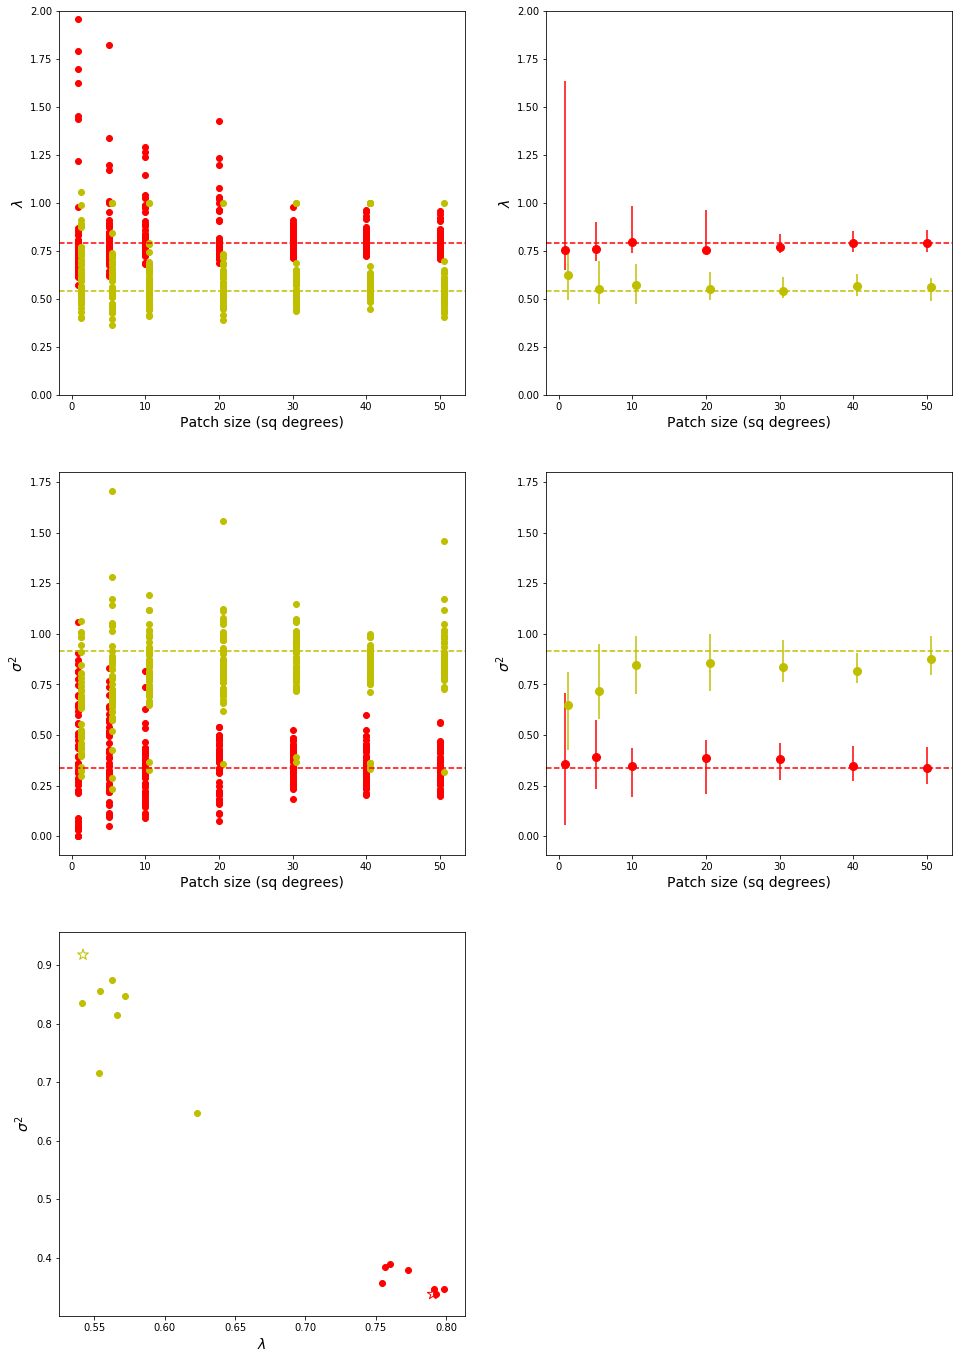

In [14]:
fig = plt.figure(figsize=(16,24))

sp1 = fig.add_subplot(321)
sp2 = fig.add_subplot(322, sharex = sp1, sharey = sp1)
sp3 = fig.add_subplot(323, sharex = sp1)
sp4 = fig.add_subplot(324, sharex = sp3, sharey = sp3)
sp5 = fig.add_subplot(325)

for k in range(len(list_sq_degrees)):
    # Log-shift parameter
    sp1.scatter(np.ones(list_no_patches[k])*list_sq_degrees[k], dict_lambda_fit[list_sq_degrees[k]], c='r')
    sp1.scatter(np.ones(list_no_patches[k])*list_sq_degrees[k]+0.5, dict_lambda_calc[list_sq_degrees[k]], c='y')
       
    sp2.errorbar(list_sq_degrees[k], np.median(dict_lambda_fit[list_sq_degrees[k]]),
                 yerr=[[np.median(dict_lambda_fit[list_sq_degrees[k]])-np.percentile(dict_lambda_fit[list_sq_degrees[k]], 16.0)],
                       [np.percentile(dict_lambda_fit[list_sq_degrees[k]], 84.0)-np.median(dict_lambda_fit[list_sq_degrees[k]])]],
                 c='r', marker='o', markersize=8)
    sp2.errorbar(list_sq_degrees[k]+0.5, np.median(dict_lambda_calc[list_sq_degrees[k]]),
                 yerr=[[np.median(dict_lambda_calc[list_sq_degrees[k]])-np.percentile(dict_lambda_calc[list_sq_degrees[k]], 16.0)],
                       [np.percentile(dict_lambda_calc[list_sq_degrees[k]], 84.0)-np.median(dict_lambda_calc[list_sq_degrees[k]])]],
                 c='y', marker='o', markersize=8)
    
    # Sigma2 parameter
    sp3.scatter(np.ones(list_no_patches[k])*list_sq_degrees[k], dict_sigma2_fit[list_sq_degrees[k]], c='r')
    sp3.scatter(np.ones(list_no_patches[k])*list_sq_degrees[k]+0.5, dict_sigma2_calc[list_sq_degrees[k]], c='y')
    
    sp4.errorbar(list_sq_degrees[k], np.median(dict_sigma2_fit[list_sq_degrees[k]]),
                 yerr=[[np.median(dict_sigma2_fit[list_sq_degrees[k]])-np.percentile(dict_sigma2_fit[list_sq_degrees[k]], 16.0)],
                       [np.percentile(dict_sigma2_fit[list_sq_degrees[k]], 84.0)-np.median(dict_sigma2_fit[list_sq_degrees[k]])]],
                 c='r', marker='o', markersize=8)
    sp4.errorbar(list_sq_degrees[k]+0.5, np.median(dict_sigma2_calc[list_sq_degrees[k]]),
                 yerr=[[np.median(dict_sigma2_calc[list_sq_degrees[k]])-np.percentile(dict_sigma2_calc[list_sq_degrees[k]], 16.0)],
                       [np.percentile(dict_sigma2_calc[list_sq_degrees[k]], 84.0)-np.median(dict_sigma2_calc[list_sq_degrees[k]])]],
                 c='y', marker='o', markersize=8)
    
    
    sp5.scatter(np.median(dict_lambda_fit[list_sq_degrees[k]]), np.median(dict_sigma2_fit[list_sq_degrees[k]]), c='r')
    sp5.scatter(np.median(dict_lambda_calc[list_sq_degrees[k]]), np.median(dict_sigma2_calc[list_sq_degrees[k]]), c='y')
    
sp1.axhline(full_map_fit_log_shift, linestyle='dashed', c='r')    
sp1.axhline(full_map_calc_log_shift, linestyle='dashed', c='y')
sp1.set_xlabel('Patch size (sq degrees)', fontsize=14)
sp1.set_ylabel('$\lambda$', fontsize=14)
sp1.set_ylim(0,2)
#sp1.legend(loc='best')

sp2.axhline(full_map_fit_log_shift, linestyle='dashed', c='r')    
sp2.axhline(full_map_calc_log_shift, linestyle='dashed', c='y')
sp2.set_xlabel('Patch size (sq degrees)', fontsize=14)
sp2.set_ylabel('$\lambda$', fontsize=14)
#sp2.legend(loc='best')

sp3.axhline(full_map_fit_sigma2, linestyle='dashed', c='r')
sp3.axhline(full_map_calc_sigma2, linestyle='dashed', c='y')
sp3.set_xlabel('Patch size (sq degrees)', fontsize=14)
sp3.set_ylabel('$\sigma^2$', fontsize=14)
#sp3.set_ylim(0,5)
#sp3.legend(loc='best')

sp4.axhline(full_map_fit_sigma2, linestyle='dashed', c='r')
sp4.axhline(full_map_calc_sigma2, linestyle='dashed', c='y')
sp4.set_xlabel('Patch size (sq degrees)', fontsize=14)
sp4.set_ylabel('$\sigma^2$', fontsize=14)
#sp4.set_ylim(0,5)
#sp4.legend(loc='best')

sp5.scatter(full_map_fit_log_shift, full_map_fit_sigma2, marker='*', s=130, facecolors='none', edgecolors='r')
sp5.scatter(full_map_calc_log_shift, full_map_calc_sigma2, marker='*', s=130, facecolors='none', edgecolors='y')
sp5.set_xlabel('$\lambda$', fontsize=14)
sp5.set_ylabel('$\sigma^2$', fontsize=14)            

# 2. Sum of density fluctuations CLT verification

Text(0.5, 1.0, 'Sum of densities different patches histogram (Not so correct approach - see next approach)')

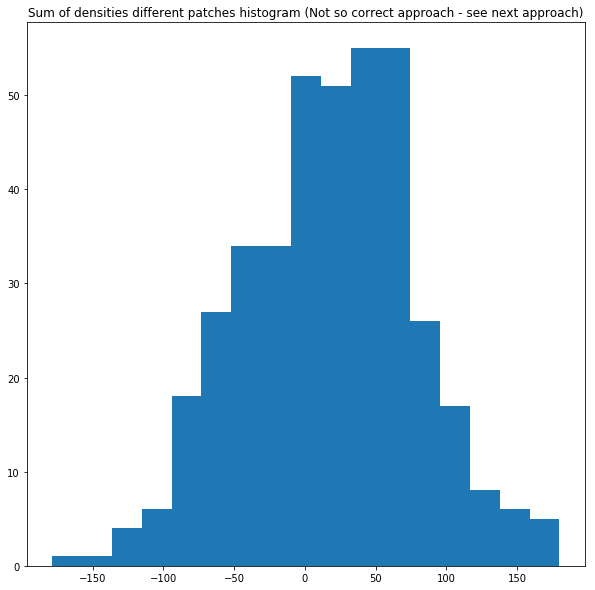

In [15]:
### distribution of sum of density fluctuations in different patches (Not so correct approach - see next approach)

sample_sets = 400 # A...Z
n = 10000 # 1...n
sum_arr = np.zeros(sample_sets)

#random_pixel = random.randint(0,12*nside**2)

for i in range(n):
    random_pixel = random.randint(0,12*nside**2)

    # Center of spherical cap around at random_pixel around which to take sq_degrees area
    disc_center = hp.pix2vec(nside, random_pixel)
    
    #sq_degrees_list = [5,10,50,250]
    #sq_degrees = random.choice(sq_degrees_list)

    sq_degrees = 0.34
    
    patch_radius = calculate_patch_radius(sq_degrees)
    
    # find the pixels 
    pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)
    density_field_disc = density_field_map[pixels_indices_disc]
    #np.random.shuffle(density_field_disc)
    sum_arr += density_field_disc[:sample_sets]
    
plt.figure(figsize=(10,10))
plt.hist(sum_arr, bins='auto')
plt.title('Sum of densities different patches histogram (Not so correct approach - see next approach)')

Text(0.5, 1.0, 'Sum of densities different patches histogram (More correct approach)')

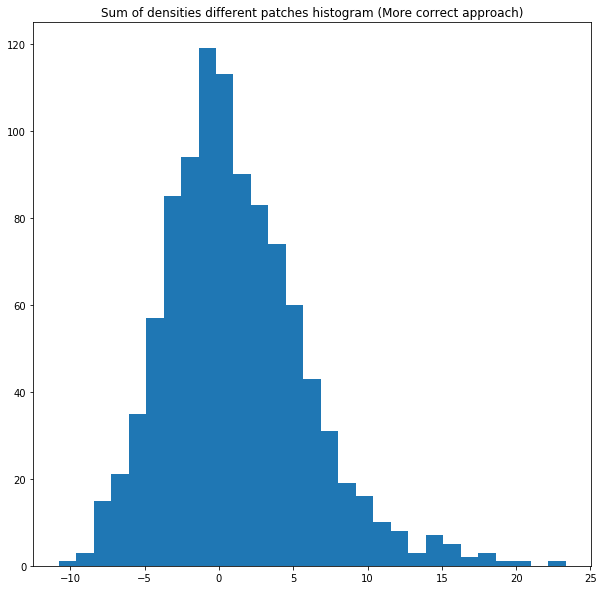

In [16]:
### distribution of sum of density fluctuations in different patches (More correct approach)

sample_sets = 1000 # A...Z
n = 50 # 1...n
sum_arr = np.zeros(sample_sets)

# Choose n random pixels
random_pixel_arr = np.random.randint(0,12*nside**2,size=n)

#random_pixel = random.randint(0,12*nside**2)

for j in range(sample_sets):
    
    for i in range(n):
        # Center of spherical cap at random_pixel i around which to take sq_degrees area
        disc_center = hp.pix2vec(nside, random_pixel_arr[i])

        #sq_degrees_list = [5,10,50,250]
        #sq_degrees = random.choice(sq_degrees_list)

        sq_degrees = 5

        patch_radius = calculate_patch_radius(sq_degrees)

        # find the pixels 
        pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)
        density_field_disc = density_field_map[pixels_indices_disc]
        np.random.shuffle(density_field_disc)
        
        sum_arr[j] += density_field_disc[0]
    
plt.figure(figsize=(10,10))
plt.hist(sum_arr, bins='auto')
plt.title('Sum of densities different patches histogram (More correct approach)')

# 3. Log-shift from histogram of - means of many small patches (Smoothing method)

### Smoothing method demonstration and CLT verification

Text(0.5, 1.0, 'Smoothing method \nSkewness of this histogram = 0.10328806814533574')

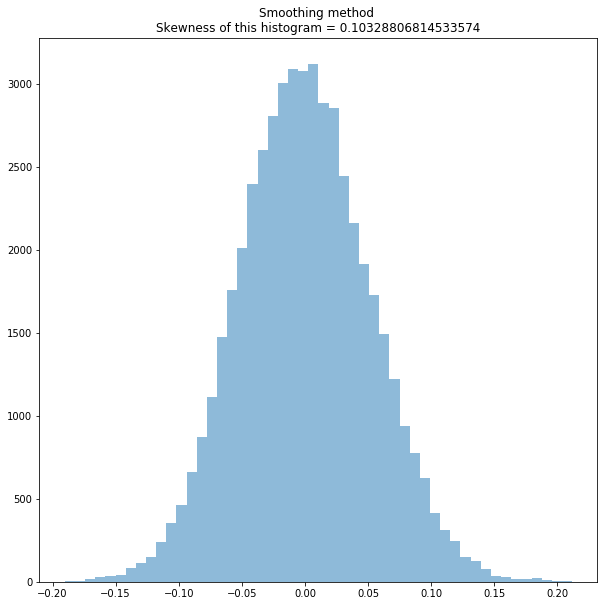

In [17]:
### smoothing method demonstration

#sample_sets = no. of entries of the point-cloud/histogram i.e. from A...Z 
sample_sets = 50000 # A...Z

mean_arr = np.zeros(sample_sets)

#random_pixel = random.randint(0,12*nside**2)

for i in range(sample_sets):
    random_pixel = random.randint(0,12*nside**2)

    # Center of spherical cap around at random_pixel around which to take sq_degrees area
    disc_center = hp.pix2vec(nside, random_pixel)
    
    # sq_degrees here actually implies the smoothing scale patch size
    
    #sq_degrees = np.pi*(20/60)**2 # At small smoothing scale patch sizes, the histogram of the point-cloud of means would look Lognormal (Oliver's idea is to calculate Log-shift parameter from this histogram)
    sq_degrees = 50 # Increasing the smoothing scale patch size will make the histogram of the point-cloud of means to tend more and more to Gaussian (verifying the CLT) 
    
    patch_radius = calculate_patch_radius(sq_degrees)
    
    # find the pixels 
    pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)
    density_field_disc = density_field_map[pixels_indices_disc]
       
    mean_arr[i] = np.mean(density_field_disc)

fig = plt.figure(figsize=(10,10))
sp1 = fig.add_subplot(111)
sp1.hist(mean_arr, bins = 50, alpha=0.5)  # Oliver
sp1.set_title('Smoothing method \nSkewness of this histogram = '+str(skew(mean_arr)))

### Estimating log-shift parameter

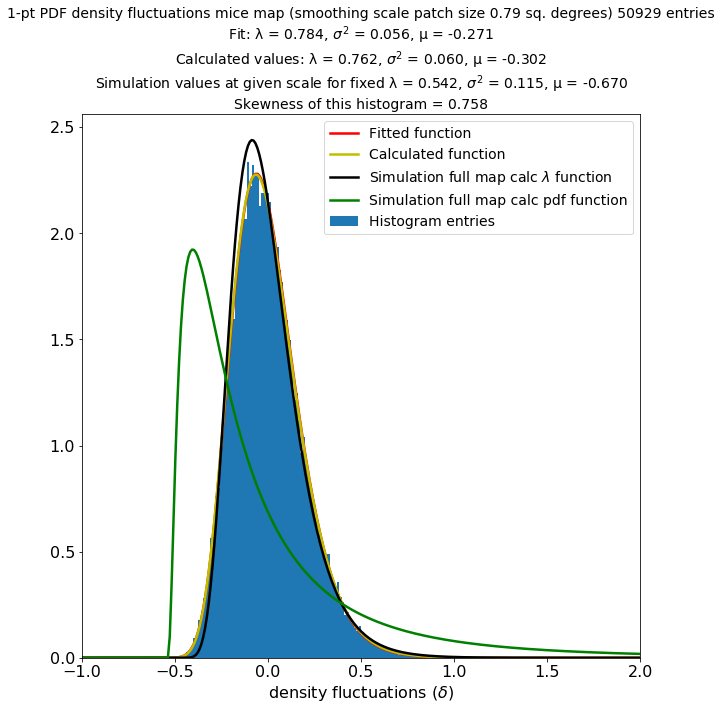

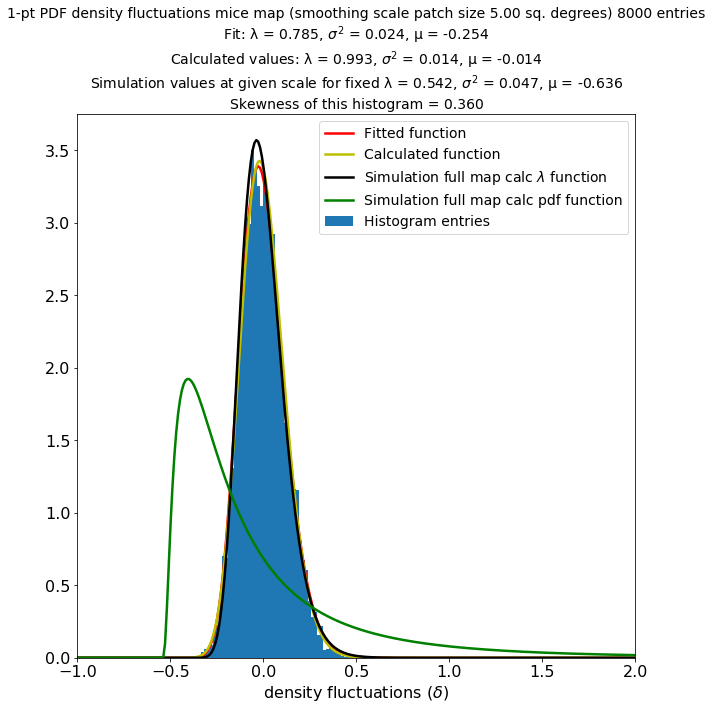

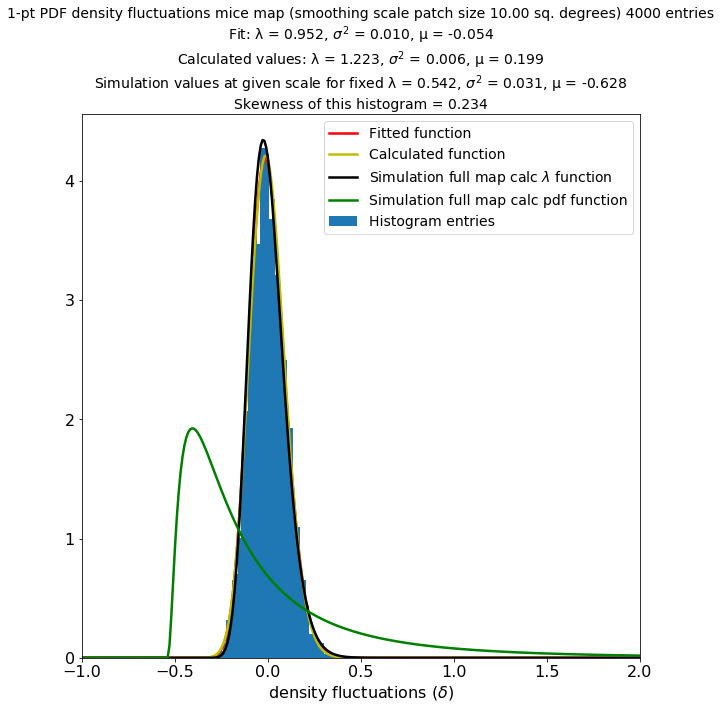

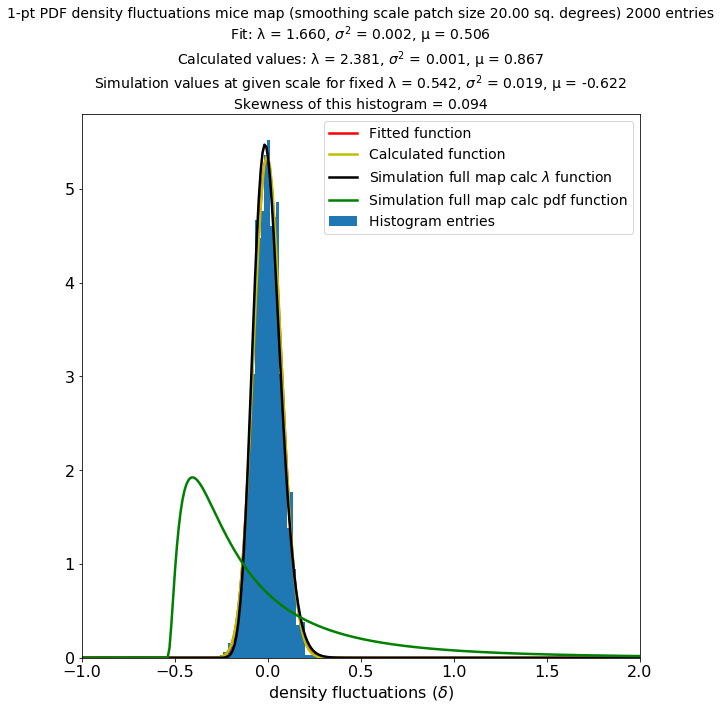

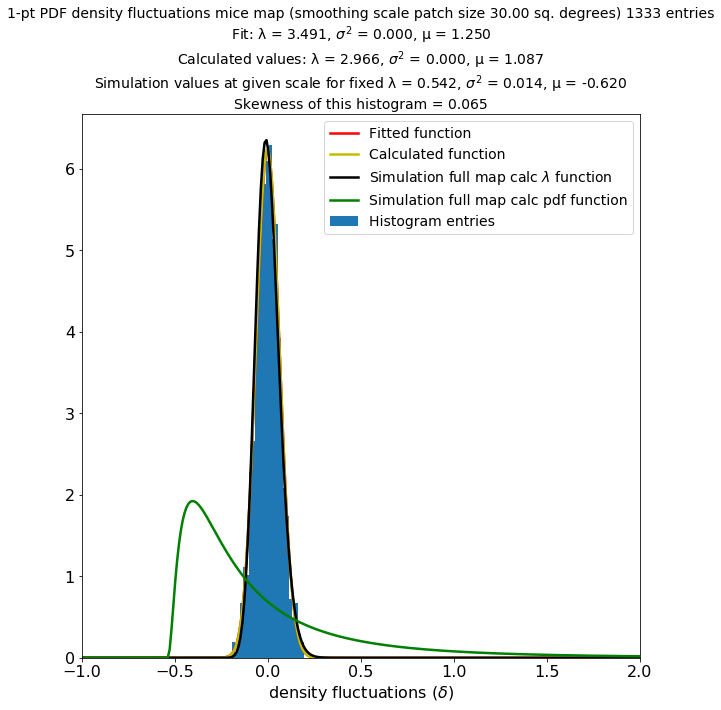

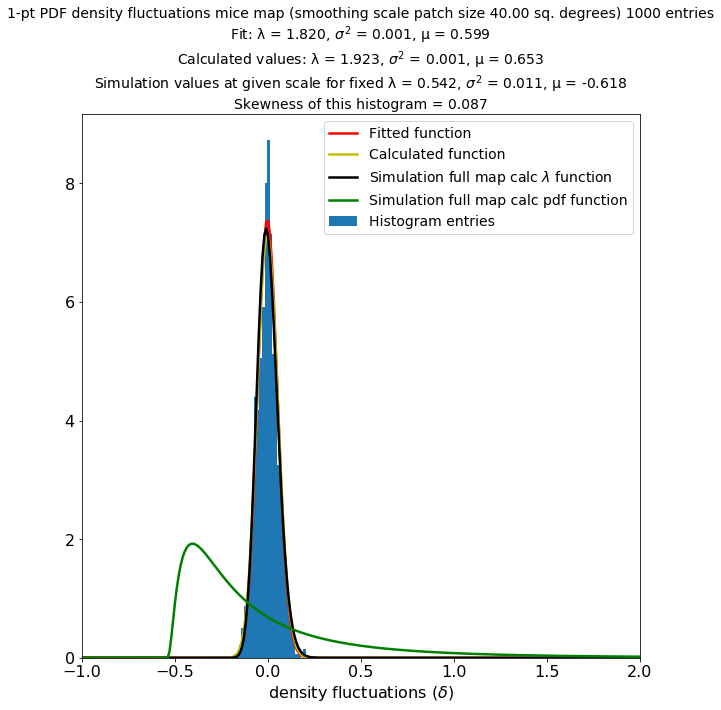

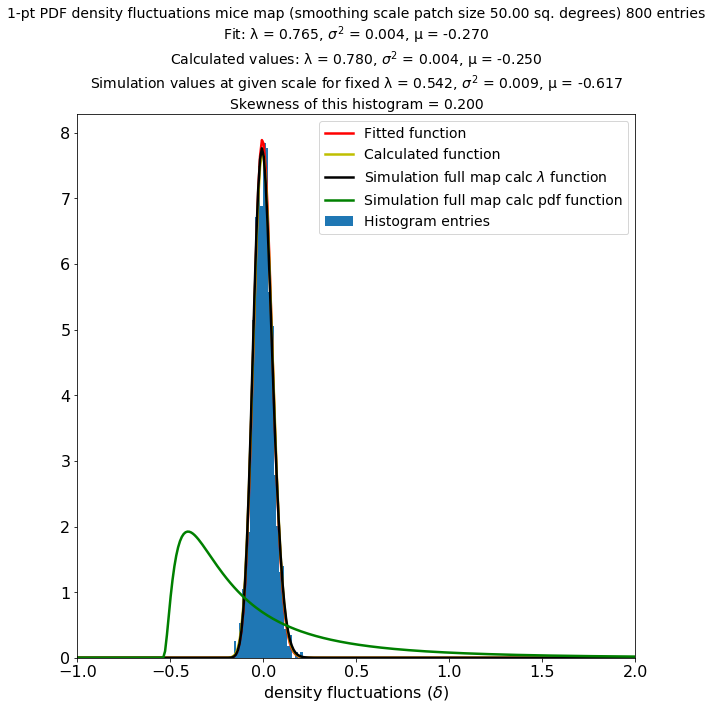

In [18]:
# smoothing scale patch size
list_sq_degrees = [np.pi*(30/60)**2, 5, 10, 20, 30, 40, 50]

list_sample_sets = []
for j in range(len(list_sq_degrees)):
    list_sample_sets.append(int(40000/list_sq_degrees[j]))
    
#print(list_sample_sets)

dict_lambda_fit = {}
dict_lambda_calc = {}

dict_sigma2_fit = {}
dict_sigma2_calc = {}

for k in range(len(list_sq_degrees)):
    
    #print(list_sq_degrees[k])
    
    sample_sets = list_sample_sets[k]
    mean_arr = np.zeros(sample_sets)
    
    sq_degrees = list_sq_degrees[k]
    patch_radius = calculate_patch_radius(sq_degrees)

    for i in range(sample_sets):
        random_pixel = random.randint(0,12*nside**2)

        # Center of spherical cap around at random_pixel around which to take sq_degrees area
        disc_center = hp.pix2vec(nside, random_pixel)

        # find the pixels
        pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)
        density_field_disc = density_field_map[pixels_indices_disc]

        mean_arr[i] = np.mean(density_field_disc)

    # As we have the point-cloud of means (mean_arr), find the log-shift parameter from the histogram of this point-cloud

    bin_values, bin_edges = np.histogram(mean_arr, bins='auto', density=True)
    bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

    # Fit the function to the histogram data to get the optimized parameter values
    #popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, p0=[1, 0.5])
    popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, bounds=(0, np.inf))

    # Calculate using formulae from Hilbert et al
    calculated_vals = calculate_logshift_sigma2_mu(mean_arr)

    # Generate enough x values to make the curves look smooth.
    x_space = np.linspace(-2, 8, 1000)
   
    e_z1z2 = moment(mean_arr, moment=2)
    sigma2 = np.log(full_map_calc_log_shift**-2*e_z1z2 + 1)
    mu = np.log(full_map_calc_log_shift)-sigma2/2

    plt.figure(figsize=(10,10))
    plt.hist(mean_arr, bins='auto', density=True, label=r'Histogram entries')
    plt.plot(x_space, lognormal_pdf(x_space, *popt), color='r', linewidth=2.5, label=r'Fitted function')
    plt.plot(x_space, lognormal_pdf(x_space, calculated_vals[0], calculated_vals[1]), color='y', linewidth=2.5, label=r'Calculated function')
    plt.plot(x_space, lognormal_pdf(x_space, full_map_calc_log_shift, sigma2), color='k', linewidth=2.5, label=r'Simulation full map calc $\lambda$ function')
    plt.plot(x_space, lognormal_pdf(x_space, full_map_calc_log_shift, full_map_calc_sigma2), color='g', linewidth=2.5, label=r'Simulation full map calc pdf function')
    plt.xlabel('density fluctuations ($δ$)', fontsize=16)
    plt.tick_params(labelsize=16)
    plt.xlim(-1,2)
    plt.title('1-pt PDF density fluctuations '+map_type+' map (smoothing scale patch size {0:4.2f} sq. degrees) {1} entries\nFit: λ = {2:4.3f}, $σ^2$ = {3:4.3f}, μ = {4:4.3f}\nCalculated values: λ = {5:4.3f}, $σ^2$ = {6:4.3f}, μ = {7:4.3f}\nSimulation values at given scale for fixed λ = {8:4.3f}, $σ^2$ = {9:4.3f}, μ = {10:4.3f}\nSkewness of this histogram = {11:4.3f}'.format(sq_degrees, mean_arr.size, popt[0], popt[1], np.log(popt[0])-popt[1]/2, calculated_vals[0], calculated_vals[1], calculated_vals[2], full_map_calc_log_shift, sigma2, mu, skew(mean_arr)), fontsize=14)
    plt.legend(loc='best', fontsize=14) 
    
    dict_lambda_fit[list_sq_degrees[k]] = popt[0]
    dict_lambda_calc[list_sq_degrees[k]] = calculated_vals[0]
    
    dict_sigma2_fit[list_sq_degrees[k]] = popt[1]
    dict_sigma2_calc[list_sq_degrees[k]] = calculated_vals[1]

Text(0, 0.5, '$\\sigma^2$')

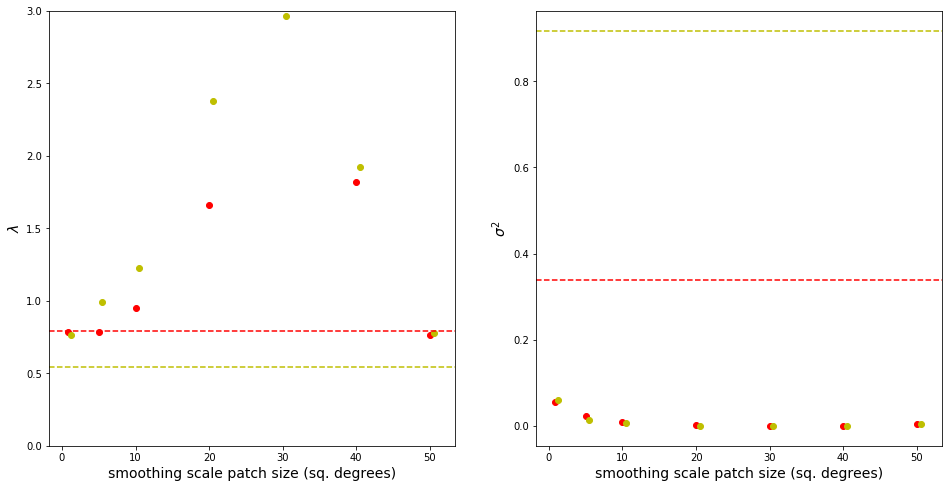

In [22]:
fig = plt.figure(figsize=(16,8))

sp1 = fig.add_subplot(121)
sp2 = fig.add_subplot(122, sharex = sp1)

for k in range(len(list_sq_degrees)):
    # Log-shift parameter
    sp1.scatter(list_sq_degrees[k], dict_lambda_fit[list_sq_degrees[k]], c='r')
    sp1.scatter(list_sq_degrees[k]+0.5, dict_lambda_calc[list_sq_degrees[k]], c='y')
    
    # Sigma2 parameter
    sp2.scatter(list_sq_degrees[k], dict_sigma2_fit[list_sq_degrees[k]], c='r')
    sp2.scatter(list_sq_degrees[k]+0.5, dict_sigma2_calc[list_sq_degrees[k]], c='y')   
    
sp1.axhline(full_map_fit_log_shift, linestyle='dashed', c='r')
sp1.axhline(full_map_calc_log_shift, linestyle='dashed', c='y')
sp1.set_xlabel('smoothing scale patch size (sq. degrees)', fontsize=14)
sp1.set_ylabel('$\lambda$', fontsize=14)
sp1.set_ylim(0,3)
#sp1.set_ylim(0,5)
#sp1.legend(loc='best')

sp2.axhline(full_map_fit_sigma2, linestyle='dashed', c='r')
sp2.axhline(full_map_calc_sigma2, linestyle='dashed', c='y')
sp2.set_xlabel('smoothing scale patch size (sq. degrees)', fontsize=14)
sp2.set_ylabel('$\sigma^2$', fontsize=14)
#sp2.legend(loc='best')

Note: In these plots, the number of patches (sample sets) - number of entries into the histogram for a given scale - decreases for increasing patch size (not set to 50 as in the other method for all scales) --> this is because we try to keep the patches independent, and of course it gets computationally more and more expensive at larger patch sizes (more no. of pixels to take mean of in larger patches). 

Reason for $\sigma^2$ decreasing at larger scales : Histogram becomes more and more Gaussian or in other words the lognormal distribution gets less and less skewed i.e. $<z1z2z3> $ approaches zero --> and according to eqn (B.11) of Hilbert et al., the $<z1z2z3> $ approaches zero when either the $\lambda$ blows up or the $<z1z2>$ $\equiv \xi_{z,12}$ goes to zero. Hence, in eqn (B.8) : $\xi_{n,12} = \ln(\lambda^{-2}\xi_{z,12} + 1)$ if the term $\lambda^{-2}\xi_{z,12}$ is very small this naturally means that $\xi_{n,12}$ $\equiv \sigma^2$ goes to zero.

Oliver: One should also take into account the fact that the equation for finding the logshift parameter i.e. (B.8) is non-linear and hence even if the inividual entries i.e. the second central moment and the third central moments are unbiased estimators, the calculated $\lambda$ is biased. Also, as the number of patches (sample sets) decreases for larger and larger smoothing scales, the noise becomes larger and we see a deviation from the actual log-shift

### Estimating log-shift parameter (demo)

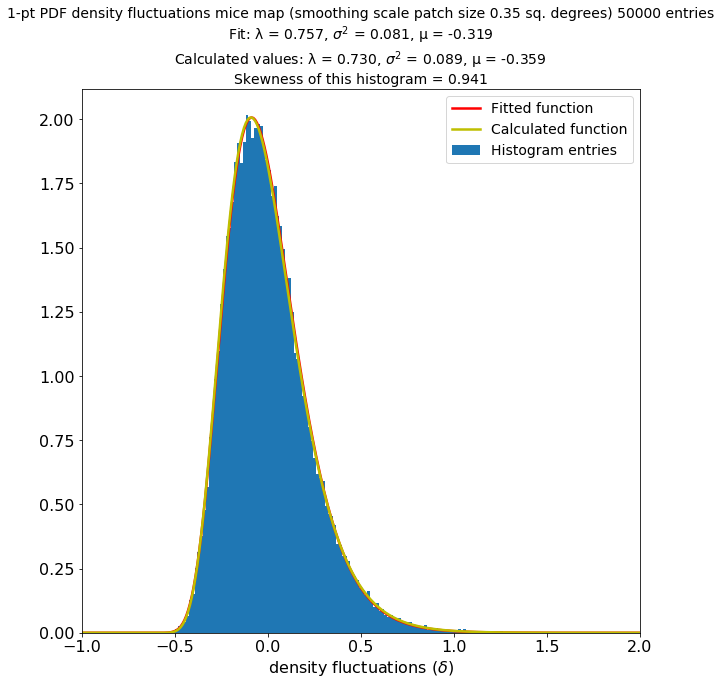

In [20]:
### Estimating log shift parameter at a given smoothing scale patch size

sample_sets = 50000
mean_arr = np.zeros(sample_sets)

sq_degrees = np.pi*(20/60)**2
patch_radius = calculate_patch_radius(sq_degrees)

for i in range(sample_sets):
    random_pixel = random.randint(0,12*nside**2)

    # Center of spherical cap around at random_pixel around which to take sq_degrees area
    disc_center = hp.pix2vec(nside, random_pixel)
       
    # find the pixels 
    pixels_indices_disc = hp.query_disc(nside, disc_center, patch_radius)
    density_field_disc = density_field_map[pixels_indices_disc]
    
    mean_arr[i] = np.mean(density_field_disc)

# As we have the point-cloud of means (mean_arr), find the log-shift parameter from the histogram of this point-cloud

bin_values, bin_edges = np.histogram(mean_arr, bins='auto', density=True)
bin_centers = np.array([0.5 * (bin_edges[i] + bin_edges[i+1]) for i in range(len(bin_edges)-1)])

# Fit the function to the histogram data to get the optimized parameter values
#popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, p0=[1, 0.5])
popt, pcov = curve_fit(lognormal_pdf, xdata = bin_centers, ydata = bin_values, bounds=(0, np.inf))

# Calculate using formulae from Hilbert et al
calculated_vals = calculate_logshift_sigma2_mu(mean_arr)

# Generate enough x values to make the curves look smooth.
x_space = np.linspace(-2, 8, 1000)

plt.figure(figsize=(10,10))
plt.hist(mean_arr, bins='auto', density=True, label=r'Histogram entries')
plt.plot(x_space, lognormal_pdf(x_space, *popt), color='r', linewidth=2.5, label=r'Fitted function')
plt.plot(x_space, lognormal_pdf(x_space, calculated_vals[0], calculated_vals[1]), color='y', linewidth=2.5, label=r'Calculated function')
plt.xlabel('density fluctuations ($δ$)', fontsize=16)
plt.tick_params(labelsize=16)
plt.tick_params(labelsize=16)
plt.xlim(-1,2)
plt.title('1-pt PDF density fluctuations '+map_type+' map (smoothing scale patch size {0:4.2f} sq. degrees) {1} entries\nFit: λ = {2:4.3f}, $σ^2$ = {3:4.3f}, μ = {4:4.3f}\nCalculated values: λ = {5:4.3f}, $σ^2$ = {6:4.3f}, μ = {7:4.3f}\nSkewness of this histogram = {8:4.3f}'.format(sq_degrees, mean_arr.size, popt[0], popt[1], np.log(popt[0])-popt[1]/2, calculated_vals[0], calculated_vals[1], calculated_vals[2], skew(mean_arr)), fontsize=14)
plt.legend(loc='best', fontsize=14) 

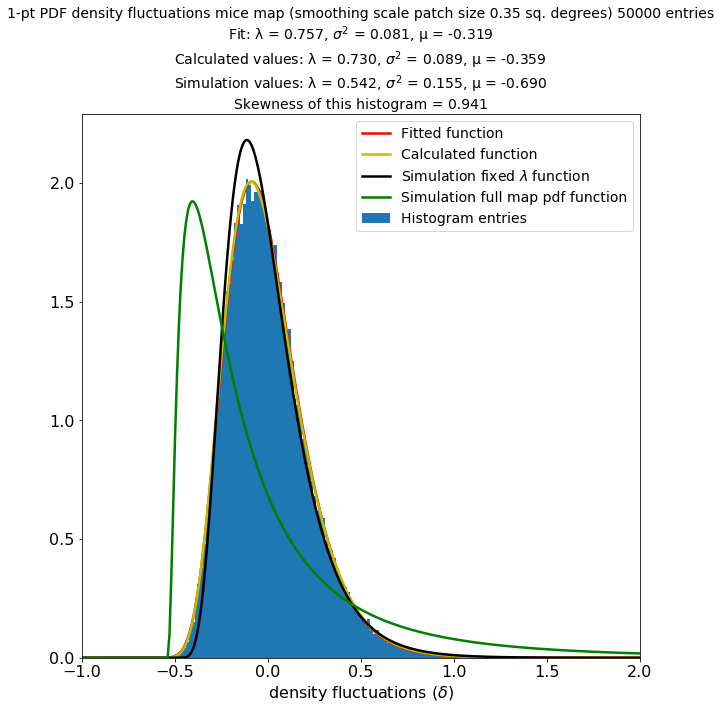

In [21]:
### smoothing approach continued
### Check the shape of the pdf at this smoothing scale patch size using the simulation log-shift value for THIS mean_arr 
### and compare to the fitted and the calculated pdfs using the respective estimated log-shift values

e_z1z2 = moment(mean_arr, moment=2)
sigma2 = np.log(full_map_calc_log_shift**-2*e_z1z2 + 1)
mu = np.log(full_map_calc_log_shift)-sigma2/2

plt.figure(figsize=(10,10))
plt.hist(mean_arr, bins='auto', density=True, label=r'Histogram entries')
plt.plot(x_space, lognormal_pdf(x_space, *popt), color='r', linewidth=2.5, label=r'Fitted function')
plt.plot(x_space, lognormal_pdf(x_space, calculated_vals[0], calculated_vals[1]), color='y', linewidth=2.5, label=r'Calculated function')
plt.plot(x_space, lognormal_pdf(x_space, full_map_calc_log_shift, sigma2), color='k', linewidth=2.5, label=r'Simulation fixed $\lambda$ function')
plt.plot(x_space, lognormal_pdf(x_space, full_map_calc_log_shift, full_map_calc_sigma2), color='g', linewidth=2.5, label=r'Simulation full map pdf function')
plt.xlabel('density fluctuations ($δ$)', fontsize=16)
plt.tick_params(labelsize=16)
plt.xlim(-1,2)
plt.title('1-pt PDF density fluctuations '+map_type+' map (smoothing scale patch size {0:4.2f} sq. degrees) {1} entries\nFit: λ = {2:4.3f}, $σ^2$ = {3:4.3f}, μ = {4:4.3f}\nCalculated values: λ = {5:4.3f}, $σ^2$ = {6:4.3f}, μ = {7:4.3f}\nSimulation values: λ = {8:4.3f}, $σ^2$ = {9:4.3f}, μ = {10:4.3f}\nSkewness of this histogram = {11:4.3f}'.format(sq_degrees, mean_arr.size, popt[0], popt[1], np.log(popt[0])-popt[1]/2, calculated_vals[0], calculated_vals[1], calculated_vals[2], full_map_calc_log_shift, sigma2, mu, skew(mean_arr)), fontsize=14)
plt.legend(loc='best', fontsize=14) 